# Testing SVR Model With Microsoft, Google, Amazon, and Apple.

This model leverages SVR for prediction of prices.

In [33]:
import os
import sys
import pandas as pd
import seaborn as sns
import pandas as pd
import ta
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, r2_score
from ta import add_all_ta_features
#import ta
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from src.visualization.visualize import DisplayTicker
from src.features.build_features import StockTechnicals
from src.models.backtest_strategy import TradeHoldStrategy


# Convert Data Function

The function below will load a CSV file with a start and end date to filter out the time range for testing. 

In addition, for feature selection, I used the following features as a test:

data_df['SMA_20'] = indicator_SMA20.sma_indicator()
data_df['bb_bbm'] = indicator_bb.bollinger_mavg()
data_df['bb_bbh'] = indicator_bb.bollinger_hband()
data_df['bb_bbl'] = indicator_bb.bollinger_lband()
data_df['MACD'] = indicator_MACD.macd()
data_df['MACD signal'] = indicator_MACD.macd_signal()

In [34]:
def convert_data(stock_ticker_csv, start_date, end_date):
    """
    stock_ticker_csv : csv file
    end_date : string
    days_to_backtrack : int
    Takes in a CSV File and converts the date to numbers
    Returns DF with Dates converted to numerical format and the original Dates for plotting
    """

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    #print(start_date)
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    #print(start_date)
    
    # set the number of days to look back
    #look_back = (end_date+timedelta(-days)).strftime('%Y-%m-%d')

    # Load the CSV File
    stock_ticker = pd.read_csv(stock_ticker_csv, index_col=['Date'], parse_dates=['Date'])
    stock_ticker.sort_values('Date')
    stock_ticker = stock_ticker[start_date: end_date]
    #print(stock_ticker.info())

    stock_ticker.reset_index(inplace=True)
    
    data_df = stock_ticker.copy()
    data_df = data_df.reset_index()
    org_dates = data_df['Date']
    data_df['Pretty Date'] = data_df['Date']
    

    # Converting Dates to Numbers - SVR doesn't work with dates
    data_df['Date'] = data_df['Date'].map(mdates.date2num)
    #print(dates_df['Date'][:5])

    indicator_bb = ta.volatility.BollingerBands(close=data_df["Close"], n=20, ndev=2)
    indicator_SMA20 = ta.trend.SMAIndicator(close=data_df["Close"],n=20, fillna=True)
    indicator_MACD = ta.trend.MACD(close=data_df["Close"],n_fast=5, n_slow=30, fillna=True)
  

    data_df['SMA_20'] = indicator_SMA20.sma_indicator()
    data_df['bb_bbm'] = indicator_bb.bollinger_mavg()
    data_df['bb_bbh'] = indicator_bb.bollinger_hband()
    data_df['bb_bbl'] = indicator_bb.bollinger_lband()
    data_df['MACD'] = indicator_MACD.macd()
    data_df['MACD signal'] = indicator_MACD.macd_signal()

    #print(len(data_df))
    # Return DF with Dates converted to numerical format and the original Dates for plotting
    return data_df, org_dates




In [35]:
start_date = '2019-01-31'
end_date = '2020-03-31'
MSFT, MSFT_dates = convert_data('./.data/MSFT.csv',start_date, end_date)
AAPL, AAPL_dates = convert_data('./.data/AAPL.csv',start_date, end_date)
AMZN, AMZN_dates = convert_data('./.data/AMZN.csv',start_date, end_date)
GOOG, GOOG_dates = convert_data('./.data/GOOG.csv',start_date, end_date)
_GSPC, _GSPC_dates = convert_data('./.data/_GSPC.csv',start_date, end_date)

# Correlation Matrix based for Microsoft

The correlation matrix is rpimted below to show how much these values move together in the same/opposite direction

In [36]:
print(MSFT.drop(columns=['index','Date','Pretty Date']).corr())

Open      High       Low     Close  Adj Close    Volume  \
Open         1.000000  0.998264  0.998022  0.996305   0.996345  0.221787   
High         0.998264  1.000000  0.997438  0.998201   0.998210  0.248192   
Low          0.998022  0.997438  1.000000  0.998460   0.998427  0.194059   
Close        0.996305  0.998201  0.998460  1.000000   0.999927  0.214544   
Adj Close    0.996345  0.998210  0.998427  0.999927   1.000000  0.215018   
Volume       0.221787  0.248192  0.194059  0.214544   0.215018  1.000000   
SMA_20       0.976928  0.981161  0.974603  0.977302   0.978645  0.289180   
bb_bbm       0.976928  0.981161  0.974603  0.977302   0.978645  0.289180   
bb_bbh       0.975496  0.981684  0.971700  0.976098   0.976789  0.338473   
bb_bbl       0.955656  0.957402  0.955182  0.955742   0.957851  0.222192   
MACD         0.516850  0.509693  0.523505  0.519196   0.512626 -0.032909   
MACD signal  0.600633  0.602044  0.598180  0.599746   0.594521  0.223849   

               SMA_20    bb_

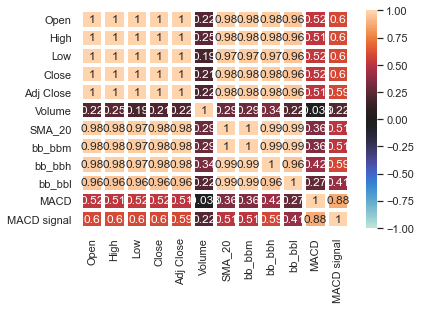

<Figure size 1152x1152 with 0 Axes>

In [6]:

corrMatrix = MSFT.drop(columns=['index','Date','Pretty Date']).corr()
import seaborn as sn
sn.heatmap(corrMatrix, 
           annot=True, 
           vmin = -1, 
           vmax=1, 
           center=0,
           fmt='.2g',
           linewidths=3,
           cbar_kws={"shrink": 1.0})
           #cmap=sns.diverging_palette(20, 220, n=200),
           ##square=True)
plt.figure(figsize = (16,16))
plt.show()


# SVC Grid Search Function

This function is used below to determine what are the best parameters for fitting the model using the given features.

In [37]:


def svc_param_selection(X, y, nfolds):
    Cs = [10, 100, 1000, 10000, 100000]
    gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_

    return grid_search.best_params_

# Model Training and Prediction Function

This function takes the ticker dataframe, forecasted number of dates (5 in this case), and tries to predict a price based on the best parameters.

In [41]:
N = 26
# create a feature matrix and some labels using our handy StockTechnicals class
MSFT_technicals = StockTechnicals(MSFT)
MSFT_X = MSFT_technicals.features
start_date = '2019-06-30'
end_date = '2020-01-31'

def convert_data_using_ta(data_in, start_date, end_date):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    #print(start_date)
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    #print(start_date)
    print(f'{data_in}')

convert_data_using_ta(MSFT_X, start_date, end_date )

index Pretty Date      SMA_20      bb_bbm      bb_bbh      bb_bbl  \
43      43  2019-08-30  136.266000  136.266000  140.175513  132.356486   
44      44  2019-09-03  136.457499  136.457499  139.900987  133.014011   
45      45  2019-09-04  136.604499  136.604499  139.984043  133.224955   
46      46  2019-09-05  136.842999  136.842999  140.478550  133.207449   
47      47  2019-09-06  136.853500  136.853500  140.513768  133.193232   
..     ...         ...         ...         ...         ...         ...   
144    144  2020-01-27  162.085999  162.085999  168.485916  155.686081   
145    145  2020-01-28  162.410999  162.410999  168.803093  156.018904   
146    146  2020-01-29  162.933498  162.933498  169.372097  156.494900   
147    147  2020-01-30  163.687498  163.687498  170.974081  156.400916   
148    148  2020-01-31  164.167998  164.167998  171.839355  156.496642   

         MACD  MACD signal    volume_adi  volume_obv  ...  momentum_uo  \
43   0.188717    -0.351928  9.021833e+07  

# Predicting Microsoft Stock Prices

SVR fails to predict well with the training data. The prediction numbers are off quite a bit, even with day 1. In looking at the chart below, it is obvious that the model appears to be overfitting and therefore cannot take properly deal with unseen data.

267   2020-02-24
268   2020-02-25
269   2020-02-26
270   2020-02-27
271   2020-02-28
Name: Date, dtype: datetime64[ns]
best_params: {'C': 10, 'gamma': 1e-05}
C: 10
Gamma: 1e-05


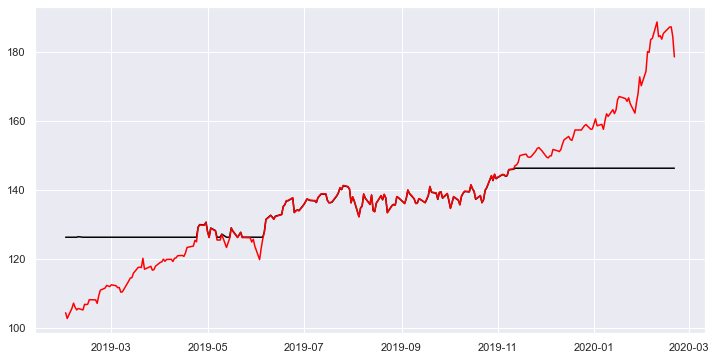

Predicted Values: [136.3224764 136.3224764 136.3224764 136.3224764 136.3224764]
Actual Values: [[170.889999]
 [168.070007]
 [170.169998]
 [158.179993]
 [162.009995]]
Model Score: 0.0


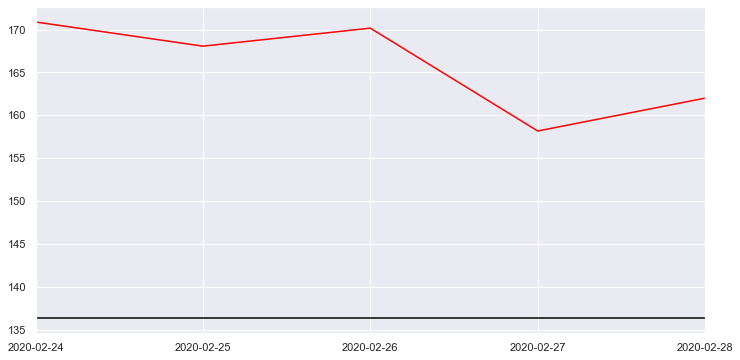

In [23]:
predict_multiple_variables(MSFT,MSFT_dates,5)

# Predicting Apple Stock Prices

267   2020-02-24
268   2020-02-25
269   2020-02-26
270   2020-02-27
271   2020-02-28
Name: Date, dtype: datetime64[ns]
best_params: {'C': 10, 'gamma': 0.0001}
C: 10
Gamma: 0.0001


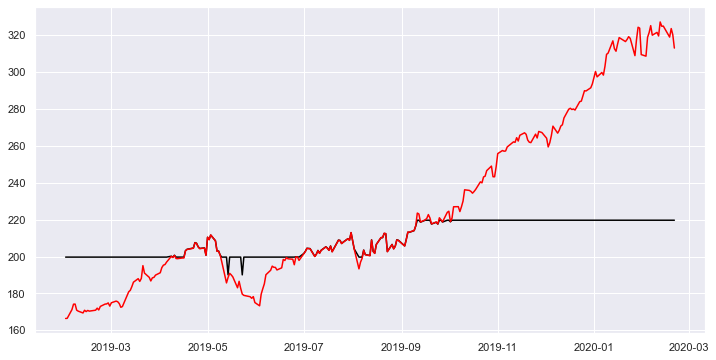

Predicted Values: [209.71097264 209.71097264 209.71097264 209.71097264 209.71097264]
Actual Values: [[298.179993]
 [288.079987]
 [292.649994]
 [273.519989]
 [273.359985]]
Model Score: 0.0


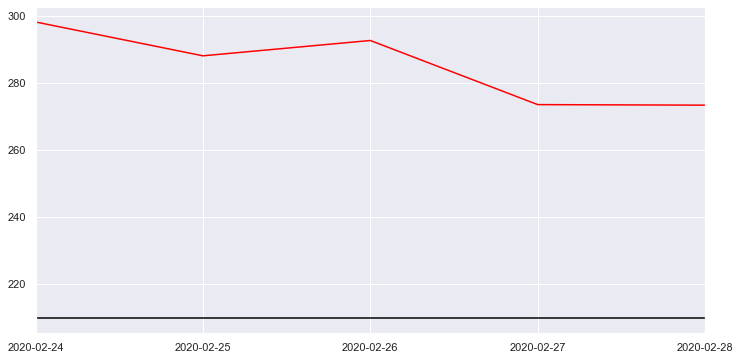

In [39]:
predict_multiple_variables(AAPL,AAPL_dates,5)

# Predicting Amazon Stock Prices

267   2020-02-24
268   2020-02-25
269   2020-02-26
270   2020-02-27
271   2020-02-28
Name: Date, dtype: datetime64[ns]
best_params: {'C': 10, 'gamma': 1e-05}
C: 10
Gamma: 1e-05


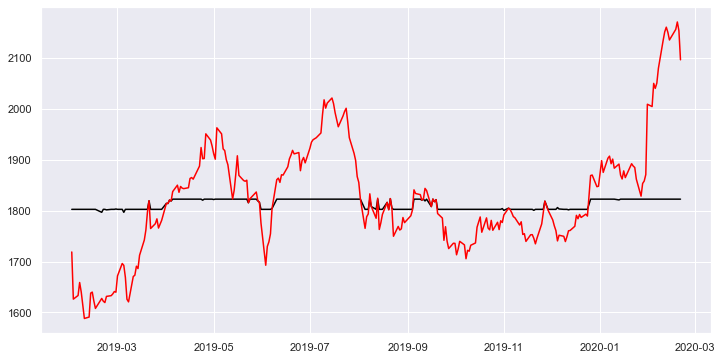

Predicted Values: [1812.43023432 1812.43023432 1812.43023432 1812.43023432 1812.43023432]
Actual Values: [[2009.290039]
 [1972.73999 ]
 [1979.589966]
 [1884.300049]
 [1883.75    ]]
Model Score: 0.0


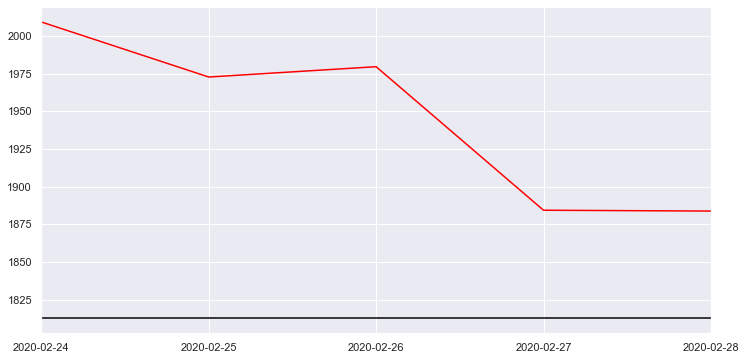

In [40]:
predict_multiple_variables(AMZN,AMZN_dates,5)

# Predicting Google Stock Prices

SVR does a poor job of adapting to unpredicted spikes when 

267   2020-02-24
268   2020-02-25
269   2020-02-26
270   2020-02-27
271   2020-02-28
Name: Date, dtype: datetime64[ns]
best_params: {'C': 10, 'gamma': 0.001}
C: 10
Gamma: 0.001


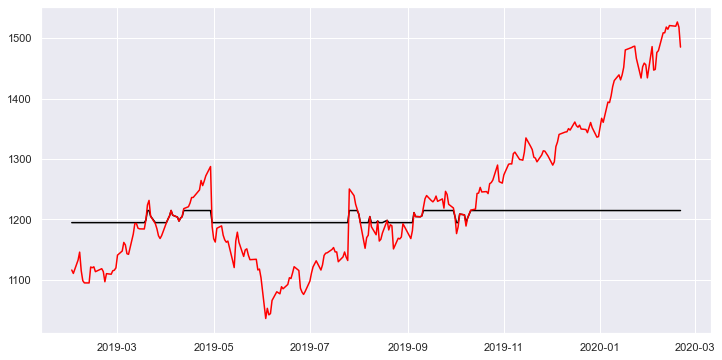

Predicted Values: [1204.7566779 1204.7566779 1204.7566779 1204.7566779 1204.7566779]
Actual Values: [[1421.589966]
 [1388.449951]
 [1393.180054]
 [1318.089966]
 [1339.329956]]
Model Score: 0.0


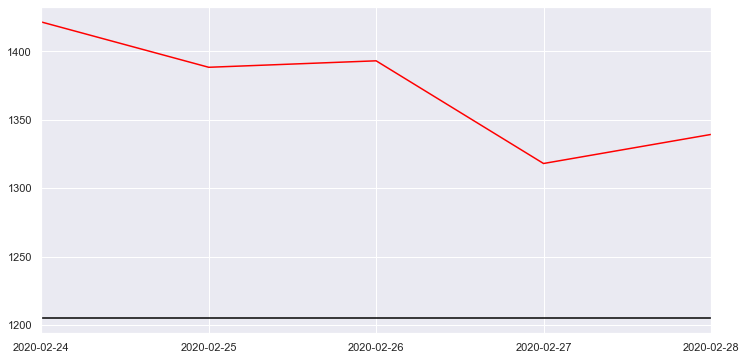

In [41]:

predict_multiple_variables(GOOG, GOOG_dates, 5)

In [38]:
def predict_multiple_variables(ticker_df, dates_org, num_forecast_days):

    num_training_days = len(ticker_df)
    print(dates_org[-num_forecast_days:])
    #print("Total Days: {}".format(num_training_days+num_forecast_days))
    #print("First Forecast date: {}".format(ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1]))
    #print("Last Forecast date: {}".format(ticker_df['Pretty Date'][-1:]))
    #print(ticker_df['Pretty Date'][-1])
    # Separate Training based on the number of training days
    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Date','SMA_20','Open','Volume', 'bb_bbl', 'MACD']]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Close']]

     # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][['Date', 'SMA_20','Open','Volume', 'bb_bbl', 'MACD']]
    test_y = ticker_df[-num_forecast_days:][['Close']]
    
    best_params = svc_param_selection(train_x, train_y, 3)
    print(f'best_params: {best_params}')
    print(f'C: {best_params["C"]}')
    print(f'Gamma: {best_params["gamma"]}')

    # Fit training data using SVR/RBF
    #svr_rbf = SVR(kernel= 'rbf', C= 10000, gamma= 0.001)
    
    svr_rbf = SVR(kernel= 'rbf', C= best_params["C"], gamma= best_params["gamma"])


    #svr_rbf.fit(train_dates[-DF_Train_Index:], train_prices[-DF_Train_Index:])
    svr_rbf.fit(train_x, train_y)

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        svr_rbf.predict(train_x), 
                        color= 'black', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'red', 
                        label= 'Train Data Actual')
    plt.show()
    
    y_pred = svr_rbf.predict(test_x)

    print("Predicted Values: {}".format(y_pred))
    print("Actual Values: {}".format(test_y.to_numpy()))
    #print("Dates: {}".format(ticker_df['Pretty Date'][-num_forecast_days:]))
    # Show explained variance 
    model_score = explained_variance_score(y_true=test_y, y_pred=y_pred)
    print("Model Score: {}".format(model_score))
    
    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    # if the forecast is one day, it will not plot a line

    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'black', 
                        label= 'Test Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'red', 
                        label= 'Actual')

    # Otherwise, plot a line for x > 1
    
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'black', 
                        label= 'Test Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'red', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.show()

    

